In [141]:
%matplotlib inline

from __future__ import print_function, division

# Author: Xiang Wang
# E-mail: wx15857152367@163.com

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, grad
import torch.nn.functional as F


from tensorboardX import SummaryWriter

import numpy as np
import time
import os
import copy
import pickle

import unicodedata
import re
import random

import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 一、数据处理与加载

基本就是读入数据，处理之后得到词典和句对，本部分基本上就是pytorch的官方代码

In [2]:
# 这里是pytorch官方的代码，主要是将编码转化成ASCII并且做了正则
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s)  if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    # 小写后去除最后的空格再经过字符的转化，最后用两个正则去除其他干扰
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) 
    return s

<B>补充注释：</B>unicodedata库主要提供访问UCD相关内容的库。UCD是Unicode字符数据库（Unicode Character DataBase）的缩写。UCD由一些描述Unicode字符属性和内部关系的纯文本或html文件组成。UCD中的文本文件大都是适合于程序分析的Unicode相关数据。其中的html文件解释了数据库的组织，数据的格式和含义。UCD中最庞大的文件无疑就是描述汉字属性的文件Unihan.txt。在UCD 5.0,0中，Unihan.txt文件大小有28,221K字节。Unihan.txt中包含了很多有参考价值的索引，例如汉字部首、笔划、拼音、使用频度、四角号码排序等。这些索引都是基于一些比较权威的辞典，但大多数索引只能检索部分汉字。

In [3]:
# 加载语料库，处理成[[language1, language2]]形式的数组
# input: lang1 第一种语言
#        lang2  第二种语言
#
# output: pairs [[language1, language2]]形式的数组

def readLangs(lang1, lang2):
    
    lines = open('D:/4.Data/Eng_Fran/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    
    pairs = [[normalizeString(word) for word in seq_seq.split('\t')] for seq_seq in lines]
    
    pairs = [list(reversed(p)) for p in pairs]

    
    return pairs


In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    
    # 处理句子，调用addWord完成词典
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

            
            
def buildLang(lang1, lang2):
    
    input_lang = Lang(lang1)
    ouput_lang = Lang(lang2)
    
    return input_lang, ouput_lang
    

In [5]:
# 为了训练的方便，这里取词库的子集来训练(两种语言的句子字长均不超过10，英语是以eng_prefixes中的词开头的句子对)
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    # startswith() 方法用于检查字符串是否是以指定子字符串开头，如果是则返回 True，否则返回 False
    return (len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes))


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2):

    pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    input_lang, output_lang = buildLang(lang1, lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [7]:
lang1 = 'eng'
lang2 = 'fra'

input_lang, output_lang, pairs = prepareData(lang1, lang2)
pairs
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
eng 4489
fra 2925
['je me porte volontaire .', 'i m volunteering .']


## 二、建立模型

![](http://pytorch.apachecn.org/cn/tutorials/_images/encoder-network.png)

In [59]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
    
    def forward(self, input, state):
        embedding_x = self.embedding(input)
        x = embedding_x.view(1, 1, -1)
        output, state = self.gru(x, state)
        return output
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=device)



![注意力机制的解码器](http://pytorch.apachecn.org/cn/tutorials/_images/attention-decoder-network.png)

这里的attention机制和李宏毅教授的attention机制不同, 这里是将当前的输入与之前的隐层拼接做DNN之后得到(1, 时序长度), 再做softmax得到权值, 最后将其与编码器的输出做乘法即可

In [120]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.attention = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    # input：上一层RNN的输出 
    # hidden：上一层隐层的值，也就是s(也就是h，为了区分写成s)
    # encoder_outputs：编码器的输出，也就是h(因为pytorch的RNN输出没有另外加激活函数，所以这里其实也就是隐层输出)
    def forward(self, input, hidden, encoder_outputs):


        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        # 先将当前的输入和前一个时刻的隐层状态拼接，按列拼接，也就是直接放在它的右边
        # 因为embedded是（1，1，256）的形式，所以embedded[0]就是（1，256）的形式；同理hidden[0]也是（1，256）
        # 结果attention之后变化为（1， max_length）
        # 用softmax把其变成概率
        attention_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # 使用unsqueeze来增加维度
        # 增加维度后：encoder_outputs为(1,10,256)
        # torch.bmm执行保存在 batch1 和 batch2 中的矩阵的批量矩阵乘法.如果 batch1 是一个 b x n x m 的张量, batch2 是一个 b x m x p 的张量
        # out 将是一个 b x n x p 的张量
        attention_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        # 将输入和注意力拼接在一起
        # output的维度为（1，512）
        # 经过全连接后变为（1，256），然后用unsqueeze增加维度（1，1，256）
        output = torch.cat((embedded[0], attention_applied[0]), 1)
        output = self.attention_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)
        
        # 通过全连接后和softmax得到概率，得到（1，output_lang.n_words)
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attention_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 三、设置必要的参数 

In [121]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


In [122]:
# 使用 SGD 来进行训练
def get_optimizer(net, lr=0.01):
    optimizer = torch.optim.SGD(net.parameters(), lr)
    return optimizer

encoder_optimizer = get_optimizer(encoder)
decoder_optimizer = get_optimizer(attn_decoder)

In [123]:
# 定义损失函数
# 用于多分类的负对数似然损失函数
criterion = nn.NLLLoss()

In [124]:
batch_size = 1

## 四、训练模型

In [125]:
# 一次训练过程（由于batchsize为1，所以这里其实就是一次batch的过程），主要分为Teacher forcing的训练方式和普通的训练方式
# Teacher forcing就是在解码器训练时候，每次的输入并不是解码器上一次得到的输出，而是真实的序列值
# 普通的训练方法就是直接将上一个解码器得到的输出直接给下一次的解码器
# input: input_tensor  第一种语言(需要被翻译的句子)
#        target_tensor 第二种语言（翻译后的句子）
#        encoder  编码器
#        decoder  解码器
#        encoder_optimizer 编码器优化
#        decoder_optimizer 解码器优化
#        max_length 最大序列长度
#
# output: 损失值
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH, teacher_forcing_ratio = 0.5):
    
    # 初始化编码器的h0,这里直接用了满足维度的0
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
     
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    # 这里的for循环是一个字一个字来进行encode，也就是说step_num = 1
    # 经过for循环后得到input_length个encode后的值（其实这里是可以不需要用for循环直接用过RNN来做到，但是可能考虑得教程的入门性质，官方没有这么做）
    for ei in range(input_length):
        # 经过编码器得到编码器全部的输出（由于这里的step_num为1，所以这里全部其实也就1个）和隐层状态
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # encoder_output[0, 0]就是将（1，1，256）变为（256）
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # 将SOS_token变成张量形式，也就是tensor([[ 0]], device='cuda:0')的样子
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # 将encoder的隐层输出作为decoder的初始h0
    decoder_hidden = encoder_hidden
    
    # 随机挑选使用哪一种方式来训练
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # 使用teacher_forcing
    # 由于使用teacher_forcing，所以序列长度一定和原来的一样，所以不需要管EOS_token
    # 但用普通方式训练时，需要用EOS_token来判断终止
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # decoder_output输出是一个softmax后得到的概率
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 计算损失
            loss += criterion(decoder_output, target_tensor[di])
            # 将真实的值作为输入进行训练
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # topk(n)返回decoder_output中的最大值n个值和其序号,这里n为1，所以就是一个值
            topv, topi = decoder_output.topk(1)
            # squeeze()将topi压缩一位，就是将[num]变为num
            decoder_input = topi.squeeze().detach()  # detach from history as input
            # 计算损失
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [126]:
# 用来处理时间的函数
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [127]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [128]:
# 得到句子中每一个字在词向量矩阵中的index
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# 得到句子中每次字在词向量矩阵中的index,并且在末尾加上EOS_token，并将其转化为一个字一个字的形式的张量
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    # 为句子末尾加上EOS_token来表示结束
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


# 分别得到需要翻译的句子和翻译后的句子的index所组成的集合
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [129]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    # 随机挑选句子对，并对其形式进行处理
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        # 得到loss
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    
    return encoder, decoder

In [151]:
encoder, attn_decoder = trainIters(encoder, attn_decoder, 75000, print_every=1000)

## 五、评估模型

和训练模型主要的区别就是让其自己生成句子

In [132]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

随机选择几个句子来翻译

In [152]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('原始句子：', pair[0])
        print('对应翻译：', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('生成翻译：', output_sentence)
        print('')

In [153]:
evaluateRandomly(encoder, attn_decoder)

原始句子： je suis flic .
对应翻译： i m a cop .
生成翻译： i m a . <EOS>

原始句子： je suis juste derriere lui .
对应翻译： i m right behind him .
生成翻译： i m right behind him . <EOS>

原始句子： je suis humble .
对应翻译： i m humble .
生成翻译： i m humble . <EOS>

原始句子： c est un professeur de notre ecole .
对应翻译： he is a teacher at our school .
生成翻译： he is a friend of our . . <EOS>

原始句子： vous savez vous faire comprendre .
对应翻译： you re assertive .
生成翻译： you re assertive . <EOS>

原始句子： je vais bien .
对应翻译： i m all right .
生成翻译： i m fine right . <EOS>

原始句子： nous devenons plus intimes .
对应翻译： we re getting closer .
生成翻译： we re getting closer . <EOS>

原始句子： vous ne rendez pas ca facile .
对应翻译： you re not making this easy .
生成翻译： you re not making this easy . <EOS>

原始句子： c est toi le prof .
对应翻译： you re the teacher .
生成翻译： you re the teacher . <EOS>

原始句子： il est notre professeur d anglais .
对应翻译： he is our teacher of english .
生成翻译： he is our teacher of english . <EOS>



## 六、可视化注意力

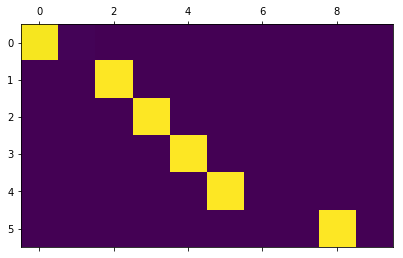

In [142]:
output_words, attentions = evaluate(encoder, attn_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


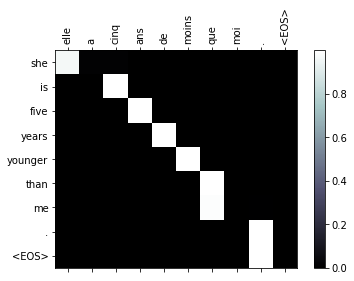

input = elle est trop petit .
output = she s too trusting . <EOS>


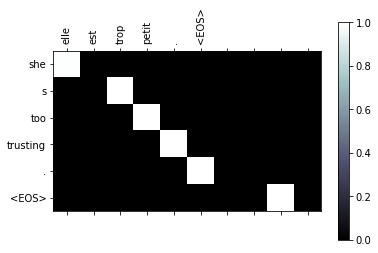

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


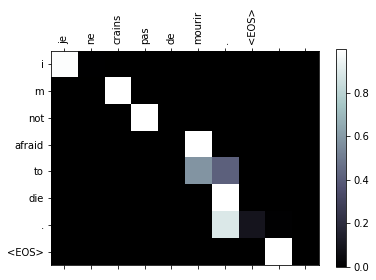

input = c est un jeune directeur plein de talent .
output = he s a fine young writer . <EOS>


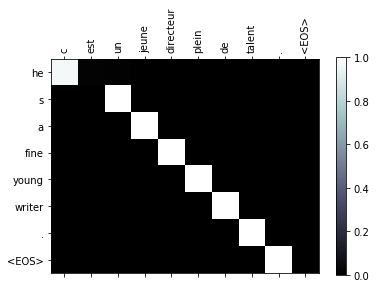

In [145]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## 七、保存模型

In [154]:
# 模型保存
torch.save(encoder, 'Encoder.pkl')
torch.save(attn_decoder, 'Decodert.pkl')

In [ ]:
# 模型加载
encoder = torch.load('Encoder.pkl')    
attn_decoder = torch.load('Decodert.pkl') 